In [2]:
# load the package
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, SetPyPlot, NLopt, Dierckx, CoolProp
import Calculus, JLD
import GR
FF = FractionalFlow

FractionalFlow

## Experimental data

In [3]:
L_core = 0.104
D_core = 0.025
poros  = 0.256
A_core  = π*D_core^2/4
V_core = A_core*L_core
PV_core = L_core*A_core*poros

swi     = 0.334 # 0.334
soi     = 1-swi
T_c     = 55.6
mu_oil = 1.04e-3*1.15 # *1.15 for temperature effect (70 -> 55)
T_K = T_c + 273.15
perm_ave = 0.001e-12 # m^2 permeability
p0 = 2000/14.7*1e5
mu_water = PropsSI("viscosity", "T", T_K, "P", p0, "H2O")
pv_inj_R_exp = [0.0, 0.029, 0.152, 0.274, 1.195, 2.177, 3.527, 4.939, 6.289, 7.700, 9.051]
R_oil_exp = [0.0, 0.043, 0.236, 0.430, 0.534, 0.564, 0.584, 0.593, 0.607, 0.610, 0.610]
R_oil_exp_int = Spline1D(pv_inj_R_exp, R_oil_exp, k=1)
pv_inj_dp = [0.08, 0.18, 0.24, 0.43, 0.61, 0.86, 1.43, 2.20, 3.02, 3.96, 4.90,
5.84, 6.80, 7.73, 8.73]
dp_exp = [0.45, 0.486813, 0.53956, 0.486813, 0.434065, 0.381318, 0.334065, 0.302197,
0.271428, 0.261538, 0.247252, 0.23956, 0.231868, 0.224175, 0.221978]*20*1e5

# estimate the injection rate
# a, b = linreg(pv_inj_R_exp[1:4], R_oil_exp[1:4])
# u_est = b*(1-swi)*poros*V_core/A_core
# u_est =  dp_exp[1]/L_core*perm_ave/(mu_oil*1.5)
# u_est = 73200/L_core*perm_ave/mu_water*0.8 # multiplie by an estimated relperm
u_est = 9/(74*3600)*13.38e-6/A_core # estimated by comparing two figures from different papers
# the injection velocity seems to be 1 ft/day real velocity (not Darcy)

pv_inj_exp = pv_inj_dp[:] # same as the time steps for the dp
R_oil = R_oil_exp_int(pv_inj_exp) # just to have both dp and R for the same time steps

pv_inj = pv_inj_exp[end]
# injection_rate = 0.00011/(3600*24) # 
injection_rate = u_est*A_core # 0.001/(3600*24) # m^3/day
recovery_final = R_oil_exp[end]

so_final = (1-recovery_final)*soi # final oil saturation

t_sec = pv_inj_exp*PV_core/injection_rate

# conversion of the input data to the right unit
u_inj   = injection_rate/A_core # Darcy velocity


9.208618977598095e-7

# Water-flooding

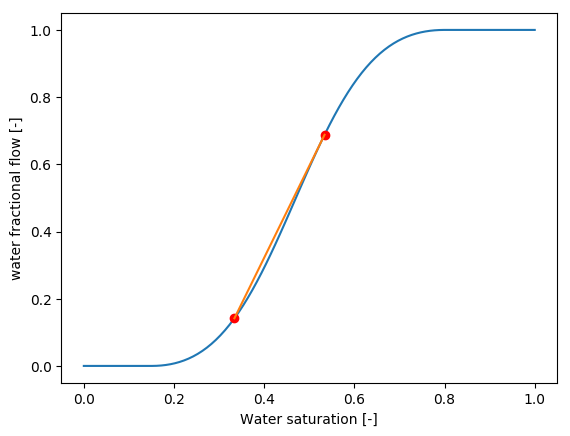

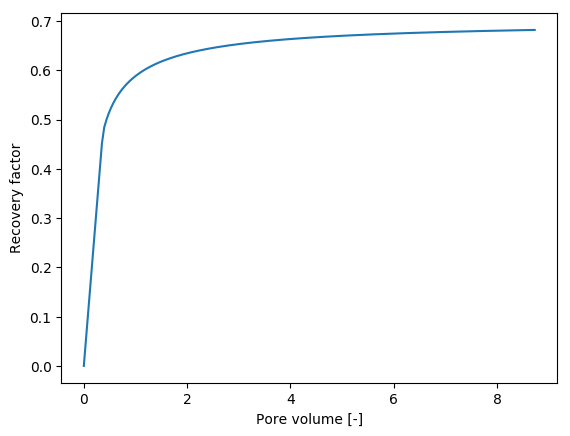

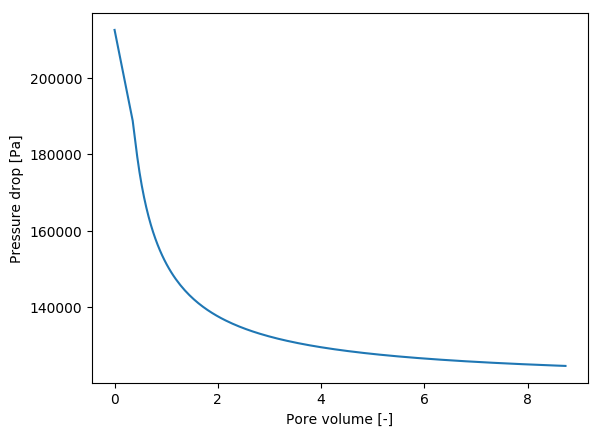

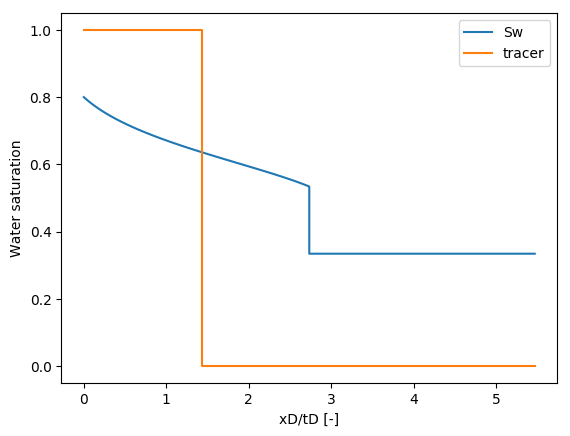

PyObject <matplotlib.legend.Legend object at 0x7fbe5f6af0d0>

In [4]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
# FF.visualize(rel_perms)
# define the fluids
fluids = FF.oil_water_fluids(mu_water=mu_water, mu_oil=mu_oil)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
# FF.visualize(rel_perms, fluids, label="lowsal")
# tight_layout()
core_flood = FF.core_flooding(u_inj=u_inj, pv_inject=pv_inj, 
    p_back=p0, sw_init=swi, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties(L=L_core, D=D_core, φ=poros, k=perm_ave)
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = linspace(0,1,100)

FF.visualize(wf_res)

In [4]:
# t_sec, pv, rec_fact, dp_core, x, sw, c, c_out_sal=
#             FF.water_flood_numeric(core_props, fluids, rel_perms, core_flood)

In [5]:
# figure()
# plot(t_sec, rec_fact, "o", wf_res.recovery_time[:,1], wf_res.recovery_time[:,2])
# figure()
# plot(t_sec, dp_core, "o", wf_res.dp_time[:,1], wf_res.dp_time[:,2])

# Experimental data


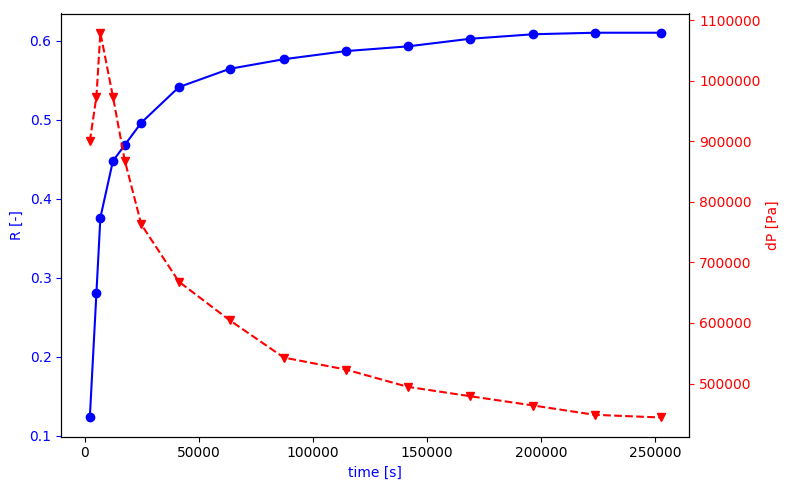

(PyPlot.Figure(PyObject <Figure size 800x500 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fbe5f5a3090>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fbe5f558c10>)

In [5]:
t_exp_dp = t_sec[:]
# dp_exp 
t_exp_R = t_sec[:]
R_exp = R_oil[:]
plotyy(t_exp_R, R_exp, t_exp_dp, dp_exp, fig_size = [8,5], x_label="time [s]", y1_label="R [-]", y2_label="dP [Pa]")

# define the objective function

In [6]:
# struct
struct exp_data
    t_exp_dp
    dp_exp
    t_exp_R
    R_exp
end
exp_data1 = exp_data(t_exp_dp, dp_exp, t_exp_R, R_exp)

exp_data([2312.96, 5204.17, 6938.89, 12432.2, 17636.3, 24864.4, 41344.2, 63606.5, 87314.4, 1.14492e5, 141669.0, 1.68846e5, 1.96602e5, 2.2349e5, 2.52402e5], [900000.0, 973626.0, 1.07912e6, 973626.0, 868130.0, 762636.0, 668130.0, 604394.0, 542856.0, 523076.0, 494504.0, 479120.0, 463736.0, 448350.0, 443956.0], [2312.96, 5204.17, 6938.89, 12432.2, 17636.3, 24864.4, 41344.2, 63606.5, 87314.4, 1.14492e5, 141669.0, 1.68846e5, 1.96602e5, 2.2349e5, 2.52402e5], [0.123024, 0.280525, 0.375934, 0.447616, 0.467941, 0.496172, 0.541179, 0.564341, 0.576489, 0.58676, 0.592751, 0.602344, 0.608086, 0.61, 0.61])

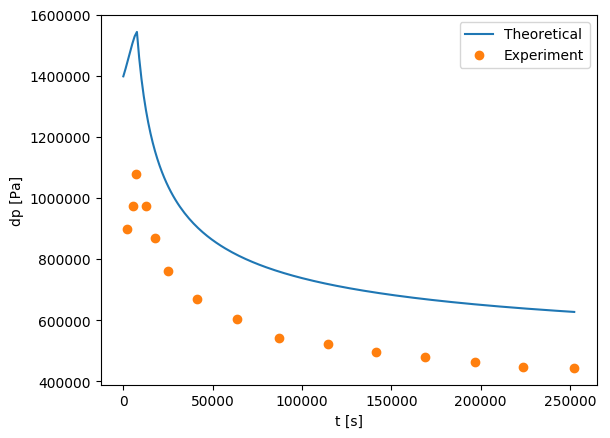

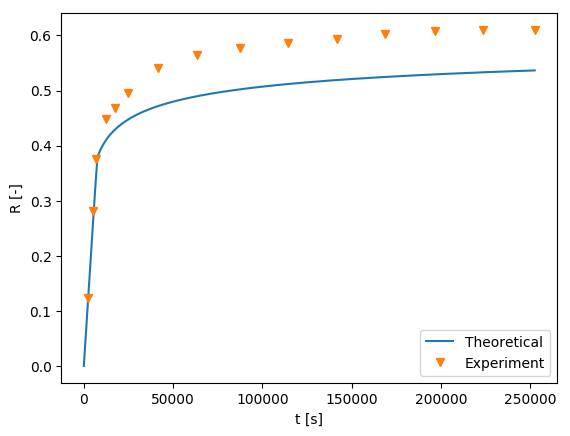

0.5139638201941595

In [7]:
"""
rel_perm_param [krw0, kro0, nw, no, swc, sor]
"""
function error_calc(rel_perm_param, exp_data, core_props, fluids, core_flood; w_p=1.0, w_R=1.0)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    dp_calc = Spline1D(wf_res.dp_time[:,1], wf_res.dp_time[:,2], k=1, bc="nearest")
    R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1, bc="nearest")
    error_dp = abs.(dp_calc(exp_data.t_exp_dp) .- exp_data.dp_exp)
#     println(error_dp)
    error_R = abs.(R_calc(exp_data.t_exp_R) .- exp_data.R_exp)
#     println(error_R)
    error_dp_norm = w_p.*error_dp./exp_data.dp_exp
    error_R_norm = w_R.*error_R./(exp_data.R_exp+eps())
    return mean(error_R_norm)+mean(error_dp_norm)
end

function vis_error(rel_perm_param, exp_data, core_props, fluids, core_flood)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    figure()
    plot(wf_res.dp_time[:,1], wf_res.dp_time[:,2],  exp_data.t_exp_dp, exp_data.dp_exp, "o")
    xlabel("t [s]")
    ylabel("dp [Pa]")
    legend(["Theoretical", "Experiment"])
    
    figure()
    plot(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], exp_data.t_exp_R, exp_data.R_exp, "v")
    xlabel("t [s]")
    ylabel("R [-]")
    legend(["Theoretical", "Experiment"])
    return wf_res
end

# test
x_init = [0.109681, 0.201297, 3.96653, 3.0, 0.19, 0.262231]

vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

# define the objective function and gradients and weight factors

In [8]:
# weight factors:
w_p = ones(length(exp_data1.dp_exp))
ind_max = indmax(exp_data1.dp_exp)
w_p[ind_max-1:ind_max+2] = 10
w_p[end:end-5]=10
w_p[1]=10
w_R = ones(length(exp_data1.R_exp))
# w_R[20:25] = 10
w_R[end:end-5]=10


function f(x)
    f_val = 0.0
    try
        f_val = error_calc(x, exp_data1, core_props, fluids, core_flood, w_p = w_p, w_R = w_R)
    catch
        f_val = 100.0
#         info("Objective function did not converge!")
    end
    return f_val
end

    
function g(x)
    eps1 = 1e-4
    f_val = f(x)
    g_val = ones(length(x))
    try
        # g_val = Calculus.gradient(x -> error_calc(x, exp_data1, core_props, fluids, core_flood), x)
        for j in eachindex(x)
            x2 = copy(x)
            x2[j]+=eps1
            f_val2 = f(x2)
            g_val[j] = (f_val2-f_val)/eps1
        end
    catch
        g_val = ones(length(x))
    end
    return g_val
end

function obj_fun(param, grad)
    if length(grad)>0
      grad[:] = g(param)
    end
    
    obj_fun_val = f(param)
    if isnan(obj_fun_val) || isinf(obj_fun_val)
        obj_fun_val = 100.0
    end
    return obj_fun_val
end

# test
grad_x = zeros(6)
obj_fun([1.0, 0.8, 3, 4, 0.2, 0.2], grad_x)

f([1.0, 0.8, 2, 2, 0.1, 0.2])

3.6157167349582657

In [16]:
grad_x

6-element Array{Float64,1}:
  0.711856
  0.495319
 -0.364036
 -0.192003
  0.139017
  1.96115 

In [11]:
## algorithms
# L: Local, G:global
# D: derivative-based, N: non-derivative (search-based)

# :LD_MMA
# :LN_COBYLA
# :LD_LBFGS
# :GN_DIRECT
# :GN_DIRECT_L
# GN_CRS2_LM
# G_MLSL_LDS
# GD_STOGO
# GN_ISRES
# GN_ESCH
# LN_NEWUOA_BOUND
# LN_BOBYQA
# LN_PRAXIS
# LN_NELDERMEAD
# LN_SBPLX
# LD_SLSQP
# LD_TNEWTON_PRECOND_RESTART
# LD_TNEWTON_RESTART
# LD_TNEWTON_PRECOND


In [17]:
x_init = [0.9, 0.8, 2.5, 2.5, 0.1, 0.1]
x_lb = [0.1, 0.1, 1.5, 1.5, 0.05, 0.1]
x_ub = [1.0, 1.0, 4.0, 4.0, core_flood.initial_water_saturation, 0.25]
opt_alg=:GN_DIRECT_L
opt1 = Opt(opt_alg, length(x_init)) # choose the algorithm
lower_bounds!(opt1, x_lb)
upper_bounds!(opt1, x_ub)
ftol_rel!(opt1, 1e-15)
ftol_abs!(opt1, 1e-15)

min_objective!(opt1, obj_fun)
(fObjOpt, paramOpt, flag) = optimize(opt1, x_init)

(0.070978892578955, [0.227374, 0.268374, 3.75437, 3.82896, 0.241672, 0.160291], :FTOL_REACHED)

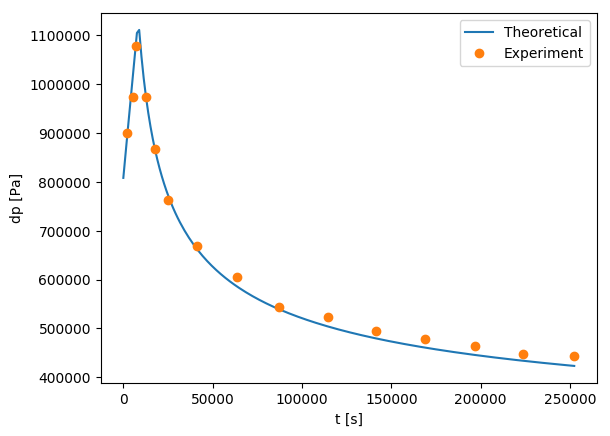

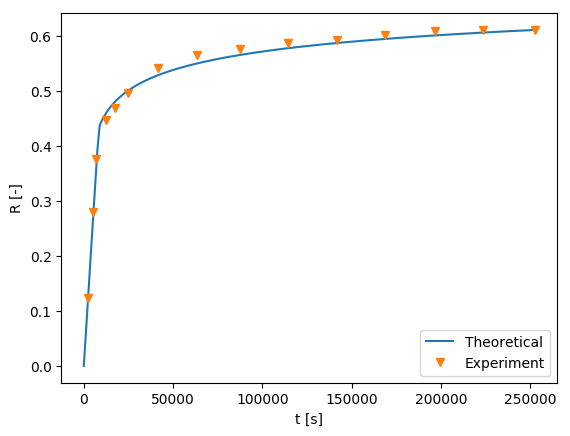

0.042180959653757094

In [11]:
# x_init = paramOpt
x_init = [0.227374, 0.268374, 3.75437, 3.82896, 0.241672, 0.160291]
wf_res = vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

In [13]:
JLD.save("/home/ali/Dropbox/presentations/20180905IEAEOR_DME/figures/exp1_fit.jld", "dp_pv", wf_res.dp_pv, 
    "R", wf_res.recovery_pv)

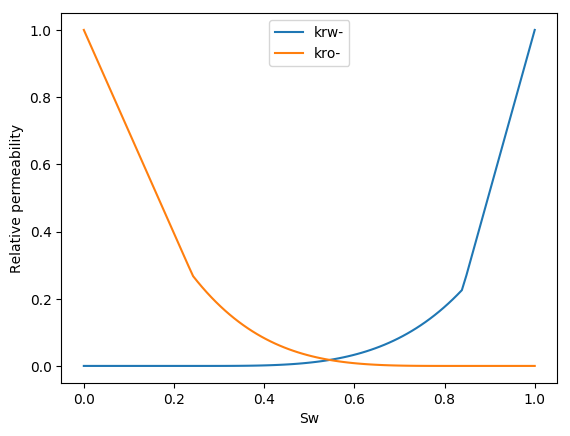

PyObject <matplotlib.legend.Legend object at 0x7fede10755d0>

In [20]:
rel_perm_param=[0.227374, 0.268374, 3.75437, 3.82896, 0.241672, 0.160291]
rel_perms2 = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
FF.visualize(rel_perms2)